In [1]:
import numpy as np
import matplotlib.pyplot as plt

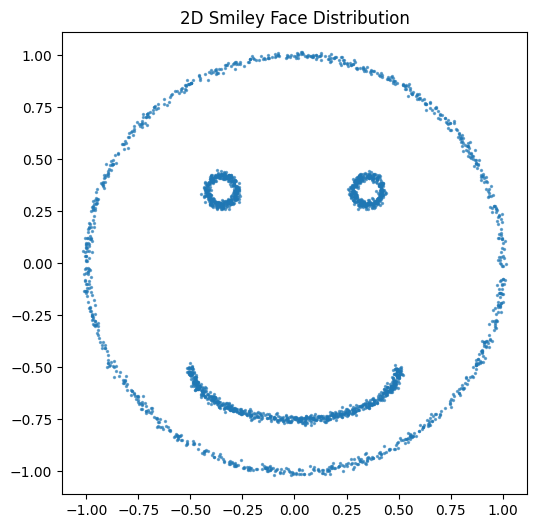

In [2]:
def sample_smiley(n_face=1000, n_eyes=350, n_smile=700, radius=1.0, noise=0.01):
    points = []

    # Face outline (circle)
    theta = np.random.uniform(0, 2*np.pi, n_face)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    points.append(np.stack([x, y], axis=1) + np.random.normal(0, noise, (n_face, 2)))

    # Eyes (two small circles)
    for cx, cy in [(-0.35, 0.35), (0.35, 0.35)]:
        theta = np.random.uniform(0, 2*np.pi, n_eyes)
        r = 0.07
        x = cx + r * np.cos(theta)
        y = cy + r * np.sin(theta)
        points.append(np.stack([x, y], axis=1) + np.random.normal(0, noise, (n_eyes, 2)))

    # Smile (semicircle)
    theta = np.random.uniform(0, np.pi, n_smile)
    r = 0.5
    x = r * np.cos(theta)
    y = -0.5 + r * np.sin(theta) * -0.5  # vertical stretch
    points.append(np.stack([x, y], axis=1) + np.random.normal(0, noise, (n_smile, 2)))

    all_points = np.concatenate(points, axis=0)
    return all_points


# Generate and plot
smiley_data = sample_smiley()

plt.figure(figsize=(6, 6))
plt.scatter(smiley_data[:, 0], smiley_data[:, 1], s=2, alpha=0.6)
plt.axis('equal')
plt.title("2D Smiley Face Distribution")
plt.show()


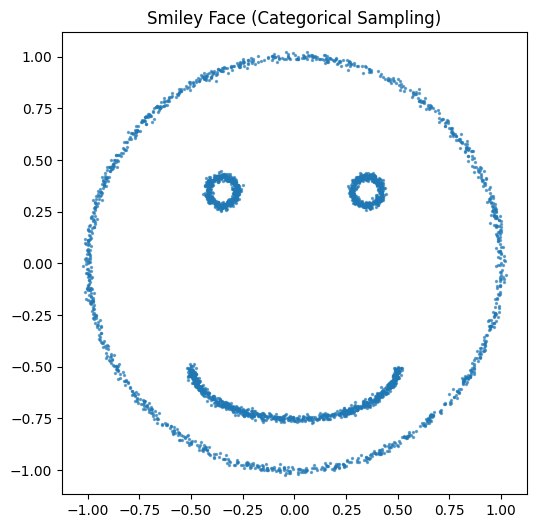

In [3]:
def sample_smiley_distribution(N=10000, noise=0.01):
    # Define component probabilities
    probs = np.array([2.857, 1.0, 1.0, 2.0]) #based on relative frequency taken from parameters for sample_smiley above (n_face=1000, n_eyes=350, n_smile=700)
    probs /= probs.sum()

    # Components: 0 = face, 1 = left eye, 2 = right eye, 3 = smile
    components = np.random.choice(4, size=N, p=probs)
    samples = []

    for comp in components:
        if comp == 0:  # face (full circle)
            theta = np.random.uniform(0, 2 * np.pi)
            r = 1.0
            x = r * np.cos(theta)
            y = r * np.sin(theta)

        elif comp == 1:  # left eye (circle)
            theta = np.random.uniform(0, 2 * np.pi)
            r = 0.07
            cx, cy = -0.35, 0.35
            x = cx + r * np.cos(theta)
            y = cy + r * np.sin(theta)

        elif comp == 2:  # right eye (circle)
            theta = np.random.uniform(0, 2 * np.pi)
            r = 0.07
            cx, cy = 0.35, 0.35
            x = cx + r * np.cos(theta)
            y = cy + r * np.sin(theta)

        elif comp == 3:  # smile (semi-circle)
            theta = np.random.uniform(0, np.pi)
            r = 0.5
            x = r * np.cos(theta)
            y = -0.5 + r * np.sin(theta) * -0.5  # vertically compressed

        # Add optional Gaussian noise
        x += np.random.normal(0, noise)
        y += np.random.normal(0, noise)
        samples.append([x, y])

    return np.array(samples)


# Example usage
data = sample_smiley_distribution(N=3000)

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=2, alpha=0.6)
plt.axis('equal')
plt.title("Smiley Face (Categorical Sampling)")
plt.show()


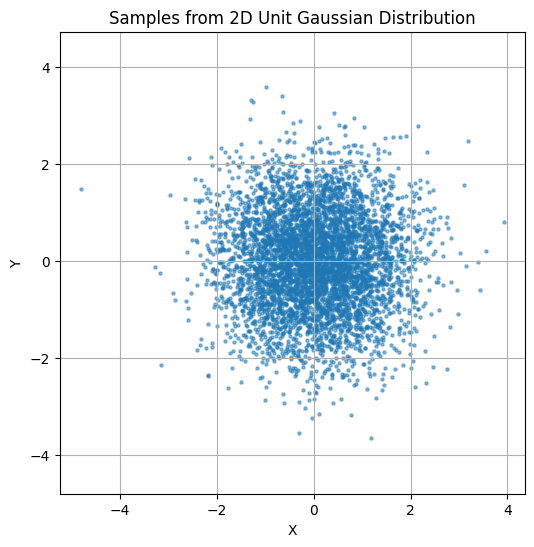

In [4]:
def generate_unit_gaussian_2d(n_samples):
  """
  Generates samples from a 2D unit Gaussian distribution.

  Args:
    n_samples: The number of samples to generate.

  Returns:
    A numpy array of shape (n_samples, 2) containing the generated samples.
  """
  # Generate samples from a 2D unit Gaussian (mean=0, variance=1)
  samples = np.random.randn(n_samples, 2)
  return samples

# Generate many samples
n_samples = 5000
gaussian_samples = generate_unit_gaussian_2d(n_samples)

# Plot the samples
plt.figure(figsize=(6, 6))
plt.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], s=5, alpha=0.5)
plt.title('Samples from 2D Unit Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()

In [14]:
import torch
from torch import nn
import torch.nn.functional as F


device = "cuda" if torch.cuda.is_available() else "cpu"

# Neural network: predict v given x_t and t
class FlowModel(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x_t, t):
        t = t.view(-1, 1)
        xtt = torch.cat([x_t, t], dim=-1)
        return self.net(xtt)

# Instantiate model and optimizer
model = FlowModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train(model, steps=100000, batch_size=1024):
    model.train()
    for step in range(steps):
        # Sample from coupling
        x_base = torch.tensor(generate_unit_gaussian_2d(batch_size), dtype=torch.float32).to(device)  # (B, 2)
        x_target = torch.tensor(sample_smiley_distribution(batch_size), dtype=torch.float32).to(device) # (B, 2)
        v_true = x_target - x_base  # (B, 2)

        t = torch.rand(batch_size, device=device)  # (B,)
        x_t = (t).unsqueeze(-1) * x_target + (1-t).unsqueeze(-1) * x_base

        # Predict velocity
        v_hat = model(x_t, t)

        loss = F.mse_loss(v_hat, v_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10000 == 0:
            print(f"[{step}] Loss: {loss.item():.6f}")

# Run training
train(model)


[0] Loss: 1.345802
[10000] Loss: 0.792477
[20000] Loss: 0.805534
[30000] Loss: 0.776918
[40000] Loss: 0.766249
[50000] Loss: 0.738586
[60000] Loss: 0.739088
[70000] Loss: 0.831433
[80000] Loss: 0.756824
[90000] Loss: 0.798726


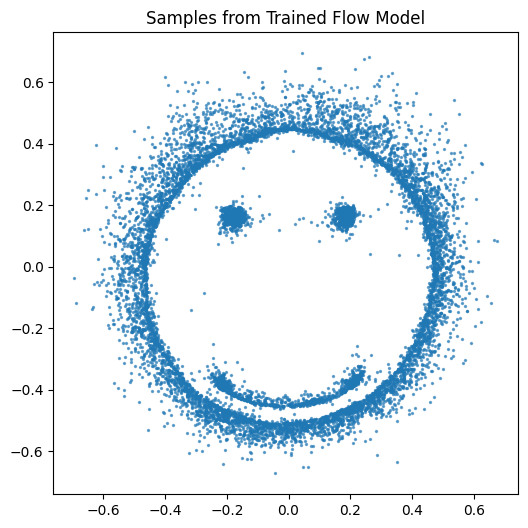

In [15]:
@torch.no_grad()
def sample_from_flow(model, n_samples=50000, n_steps=1000):
    model.eval()
    x = torch.tensor(generate_unit_gaussian_2d(n_samples=n_samples), dtype=torch.float32).to(device)  # Start at t=1
    t_vals = torch.linspace(1.0, 0.0, steps=n_steps + 1).to(device)

    for i in range(n_steps):
        t = t_vals[i]
        dt = t_vals[i] - t_vals[i+1]  # positive step size
        v = model(x, t.expand(n_samples))
        x = x + dt * v

    return x.cpu().numpy()  # shape: (n_samples, 2)

samples = sample_from_flow(model, n_samples=10000)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.6)
plt.axis('equal')
plt.title("Samples from Trained Flow Model")
plt.show()
